[RNN を使ったテキスト分類  \|  TensorFlow Core](https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=ja)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### IMDB 映画レビュー大型データセット

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

encoder = info.features['text'].encoder # 任意の文字列をエンコードする

In [3]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
for index in encoded_string:
  print ('{:4} ----> {:4}'.format(index, encoder.decode([index])))

4025 ----> Hell
 222 ----> o   
6307 ----> Ten 
2327 ----> sor 
4043 ----> Fl  
2120 ----> ow  
7975 ----> .   


### 訓練用データの準備

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

### モデルの作成

- `tf.keras.layers.Bidirectional` ラッパーは、入力を RNN 層の順方向と逆方向に伝え、その後出力を結合するため、RNN は長期的な依存関係を学習できる

In [18]:
# 時間短縮のために 64 を 16 に変えている
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',  #tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 135,729
Trainable params: 135,729
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(train_dataset, epochs=5, # エポックも少なめに設定
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 340s 870ms/step - loss: 0.5461 - accuracy: 0.7053 - val_loss: 0.4643 - val_accuracy: 0.7885
Epoch 2/5
391/391 [==============================] - 331s 845ms/step - loss: 0.3553 - accuracy: 0.8581 - val_loss: 0.4135 - val_accuracy: 0.8318
Epoch 3/5
391/391 [==============================] - 332s 849ms/step - loss: 0.2867 - accuracy: 0.8918 - val_loss: 0.4194 - val_accuracy: 0.8234
Epoch 4/5
391/391 [==============================] - 343s 878ms/step - loss: 0.2369 - accuracy: 0.9137 - val_loss: 0.3849 - val_accuracy: 0.8490
Epoch 5/5
391/391 [==============================] - 335s 858ms/step - loss: 0.2040 - accuracy: 0.9270 - val_loss: 0.4158 - val_accuracy: 0.8359


In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 51s 131ms/step - loss: 0.4123 - accuracy: 0.8360
Test Loss: 0.41226276755332947
Test Accuracy: 0.8359599709510803


予測値が 0.5 以上であればポジティブ、それ以下はネガティブ

In [21]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sentence, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

In [22]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.44451433]]


In [23]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.2767998]]


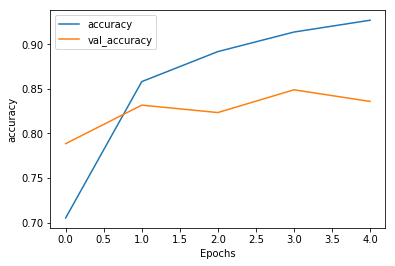

In [24]:
plot_graphs(history, 'accuracy')

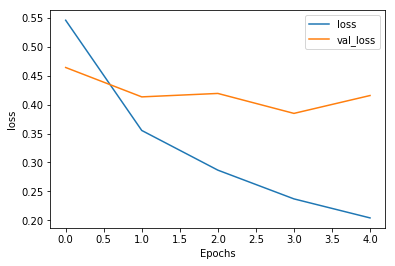

In [25]:
plot_graphs(history, 'loss')